<a href="https://colab.research.google.com/github/JonMeister/ProyectoNavierStokes/blob/main/Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Método de Newton-Raphson para resolver el sistema no lineal**

Este notebook implementa la solución de un sistema no lineal usando el **método de Newton-Raphson**, aplicado a una malla 2D con condiciones de frontera.

---

## **Descripción del problema**

Se busca encontrar una solución para Vx en un dominio 2D con condiciones de frontera conocidas, resolviendo la ecuación:
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1EFQYXzXAyQc1cXXEZgLjbn59UgGF3-pM" width="600"/>
</p>

### **Promedio de los vecinos**
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1UWHwcZAaN7RfuhoSziBaR9wyXYfL-wad" width="400"/>
</p>
Este término calcula un promedio de las velocidades en las posiciones de los nodos vecinos más cercanos en las cuatro direcciones: arriba, abajo, izquierda y derecha.

### **Término de corrección**
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=18ATjH2vO8Z9xC0PUZrO4VNb7SzvXLdNf" width="400"/>
</p>

Este término ajusta la velocidad 𝑣𝑥 en función de la diferencia en la velocidad 𝑣𝑥 entre los nodos vecinos en la dirección 𝑥, ponderado por el tamaño de la malla ℎ y la velocidad en (𝑖,𝑗).

---

## **Componentes principales**

- `idx(i, j, ny)`: Mapeo del índice 2D al índice 1D para nodos interiores.
- `compute_F(vx, vy, h, nx, ny)`: Calcula el vector residual **F**.
- `compute_jacobian_vx(vx, vy, h, nx, ny)`: Construye el Jacobiano **J = F/Vx**.
- `newton_solver_vx(...)`: Aplica Newton-Raphson para resolver **F(Vx) = 0** de forma iterativa.

---

## **Resultado**
- Se visualiza la distribución final de V𝑥 en el dominio.
- El método de Newton-Raphson ajusta iterativamente la solución hasta que el residuo ∣∣𝐹∣∣ es menor que la tolerancia dada.


Iteración 0: ||F|| = 1.59e+01
Iteración 1: ||F|| = 1.65e+01
Iteración 2: ||F|| = 7.29e-01
Iteración 3: ||F|| = 1.89e-03
Iteración 4: ||F|| = 8.22e-08
Convergencia alcanzada.


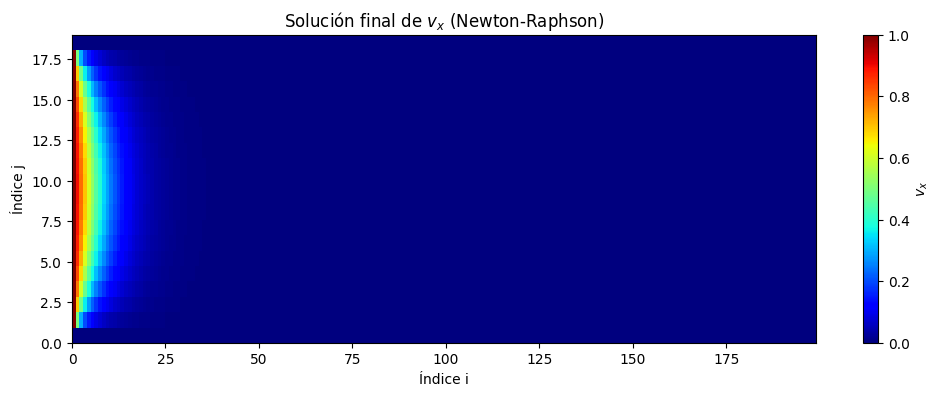

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Función de mapeo por fila para nodos interiores:
# Nodos interiores: i=1,...,nx-2, j=1,...,ny-2
def idx(i, j, ny):
    return (i - 1) * (ny - 2) + (j - 1)

def compute_F(vx, vy, h, nx, ny):
    """
    Calcula el vector residual F para cada nodo interior,
    usando la ecuación:

      F_{i,j}(v_x) = v_x(i,j) - 1/4 * [ v_x(i+1,j) + v_x(i-1,j) + v_x(i,j+1) + v_x(i,j-1)
                         - (h/2)*v_x(i,j)*(v_x(i+1,j)-v_x(i-1,j))
                         - (h/2)*v_y(i,j)*(v_x(i,j+1)-v_x(i,j-1)) ]
    """
    F = np.zeros((nx - 2, ny - 2))
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            term = vx[i+1, j] + vx[i-1, j] + vx[i, j+1] + vx[i, j-1]
            conv1 = (h/2.0) * vx[i, j] * (vx[i+1, j] - vx[i-1, j])
            conv2 = (h/2.0) * vy[i, j] * (vx[i, j+1] - vx[i, j-1])
            F[i-1, j-1] = vx[i, j] - 0.25 * (term - conv1 - conv2)
    return F.flatten()

def compute_jacobian_vx(vx, vy, h, nx, ny):
    """
    Construye el Jacobiano de F respecto a vx en los nodos interiores.

    Se usan las derivadas:
      - Diagonal: ∂F/∂vx(i,j) = 1 + (h/(8))*[vx(i+1,j)-vx(i-1,j)]
      - Vecino este:  ∂F/∂vx(i+1,j) = -1/4 + (h/(8))*vx(i,j)
      - Vecino oeste:  ∂F/∂vx(i-1,j) = -1/4 - (h/(8))*vx(i,j)
      - Vecino norte:  ∂F/∂vx(i,j+1) = -1/4 + (h/(8))*vy(i,j)
      - Vecino sur:    ∂F/∂vx(i,j-1) = -1/4 - (h/(8))*vy(i,j)

    Se asume que los vecinos que no son nodos interiores ya tienen valores fijos.
    """
    alpha = 0.5 * h  # Factor h/2
    N = (nx - 2) * (ny - 2)
    rows = []
    cols = []
    data = []

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            k = idx(i, j, ny)
            # Derivada diagonal: ∂F/∂vx(i,j)
            diag = 1.0
            # Contribución de la parte convectiva:
            if i + 1 < nx:
                diag += 0.25 * alpha * vx[i+1, j]
            if i - 1 >= 0:
                diag -= 0.25 * alpha * vx[i-1, j]
            rows.append(k)
            cols.append(k)
            data.append(diag)

            # Vecino al este: vx(i+1,j)
            if i + 1 < nx - 1:  # interior
                k_east = idx(i + 1, j, ny)
                val_east = -0.25 + 0.25 * alpha * vx[i, j]
                rows.append(k)
                cols.append(k_east)
                data.append(val_east)

            # Vecino al oeste: vx(i-1,j)
            if i - 1 >= 1:  # interior
                k_west = idx(i - 1, j, ny)
                val_west = -0.25 - 0.25 * alpha * vx[i, j]
                rows.append(k)
                cols.append(k_west)
                data.append(val_west)

            # Vecino al norte: vx(i,j+1)
            if j + 1 < ny - 1:  # interior
                k_north = idx(i, j + 1, ny)
                val_north = -0.25 + 0.25 * alpha * vy[i, j]
                rows.append(k)
                cols.append(k_north)
                data.append(val_north)

            # Vecino al sur: vx(i,j-1)
            if j - 1 >= 1:  # interior
                k_south = idx(i, j - 1, ny)
                val_south = -0.25 - 0.25 * alpha * vy[i, j]
                rows.append(k)
                cols.append(k_south)
                data.append(val_south)

    J = sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()
    return J

def newton_solver_vx(vx, vy, h, nx, ny, solver, max_iter=50, tol=1e-6):
    """
    Resuelve el sistema F(vx) = 0 para los nodos interiores mediante Newton-Raphson.
    Se actualiza únicamente vx en el dominio interior, reimponiéndose las condiciones
    de frontera en cada iteración.
    """
    for it in range(max_iter):
        F = compute_F(vx, vy, h, nx, ny)
        normF = np.linalg.norm(F)
        print(f"Iteración {it}: ||F|| = {normF:.2e}")
        if normF < tol:
            print("Convergencia alcanzada.")
            break
        J = compute_jacobian_vx(vx, vy, h, nx, ny)
        delta = solver(J, -F)
        if delta is None:
            print("Se detiene el método de Newton-Raphson porque el sistema lineal no pudo resolverse con gradiente descendente.")
            return None
        # Actualizamos los nodos interiores:
        vx_interior = vx[1:nx-1, 1:ny-1].flatten() + delta
        vx[1:nx-1, 1:ny-1] = vx_interior.reshape((nx-2, ny-2))
        # Reimponemos las condiciones de frontera:
        vx[0, :] = 1.0   # Borde izquierdo:
        vx[-1, :] = 0.0   # Borde derecho
        vx[:, 0] = 0.0    # Borde inferior
        vx[:, -1] = 0.0   # Borde superior
    return vx

# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))
    # Imponemos la condición de frontera izquierda:
    vx[0, :] = 15

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver=spla.spsolve)

    # Ploteamos la solución de vx:
    plt.figure(figsize=(12, 4))
    plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
               extent=[0, nx-1, 0, ny-1])
    plt.colorbar(label='$v_x$')
    plt.title('Solución final de $v_x$ (Newton-Raphson)')
    plt.xlabel('Índice i')
    plt.ylabel('Índice j')
    plt.show()

# **Aplicando Método de Richardson**

Este método iterativo se utiliza para resolver sistemas lineales de la forma 𝐴𝑥 = 𝑏 mediante una técnica de relajación que actualiza la solución paso a paso.

---

## **Método Iterativo de Richardson**

La función `richardson_solver` implementa el método de Richardson, que actualiza la solución iterativa con la fórmula:

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1E-U0R8YCk0oCojHqD9APBFkCDb2kRWyi" width="400"/>
</p>

---

## **¿Es Richardson el mejor método para este problema?**

### ✅ **Ventajas:**

- **Implementación muy simple**: Su estructura lo hace ideal para prototipos y pruebas rápidas.
- **Fácil de entender y modificar**: Buen punto de partida para experimentar con iterativos.
- **Compatible con matrices dispersas**: Solo requiere producto matriz-vector.

### ❌ **Limitaciones importantes:**

- **Muy sensible al valor de  ω: Un valor mal elegido puede provocar que el método diverja o se vuelva extremadamente lento.
- **Problemas con mallas grandes**: El condicionamiento del Jacobiano se deteriora con mallas finas, haciendo que el método no converja fácilmente.
- **No es robusto sin precondicionadores**: En la práctica, sufre mucho sin estrategias adicionales como precondicionamiento o aceleración.
- Lenta convergencia en sistemas grandes y dispersos.Para problemas con muchas ecuaciones (como los generados por mallas 2D), converge muy lentamente, especialmente si la matriz es mal condicionada o tiene autovalores muy distintos en magnitud.
- No aprovecha la estructura del Jacobiano dado que es disperso y estructurado


Iteración 0: ||F|| = 4.62e-01
Estimación ρ(I - A) = 0.997
Richardson convergió en 3160 iteraciones.
Iteración 1: ||F|| = 2.65e+00
Estimación ρ(I - A) = 0.997
Richardson convergió en 4810 iteraciones.
Iteración 2: ||F|| = 1.21e-03
Estimación ρ(I - A) = 0.997
Richardson convergió en 2903 iteraciones.
Iteración 3: ||F|| = 6.46e-08
Convergencia alcanzada.


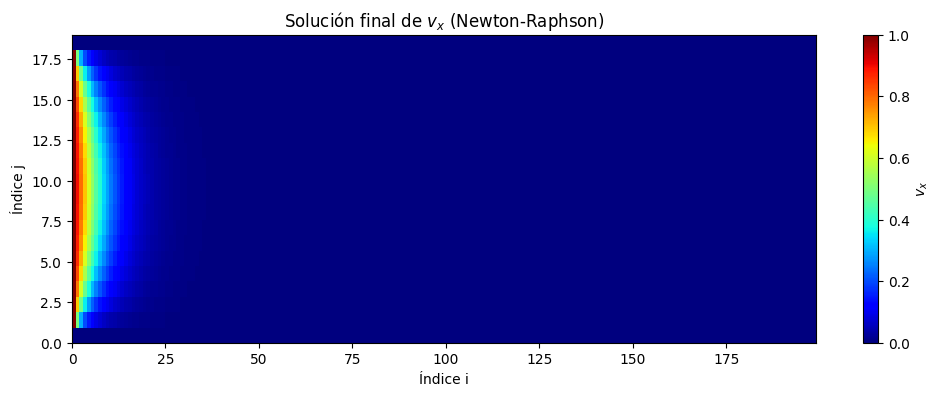

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh



def richardson_solver(A, b, x0=None, omega=None, tol=1e-8, maxiter=5000):
    """
    Método de Richardson para resolver el sistema lineal Ax = b de forma iterativa.
    Se comprueba además la condición de convergencia:
        espectro(I - ω A) ⊂ disco unidad.
    """
    # vector inicial
    x = np.zeros_like(b) if x0 is None else x0.copy()

    # estimar autovalores extremos de A
    if sp.issparse(A):
        # más grande
        lambda_max = eigsh(A, k=1, which='LM',
                           return_eigenvectors=False)[0]
        # más pequeño
        lambda_min = eigsh(A, k=1, which='SM',
                           return_eigenvectors=False)[0]
    else:
        # densa: usar norma 2 y simetría aprox.
        lambda_max = np.linalg.norm(A, 2)
        # para lambda_min en densa SPD aproximamos
        w, _ = np.linalg.eig(A)
        lambda_min = np.min(w)

    # elegir omega si no viene dado
    if omega is None:
        omega = 1.0 / lambda_max

    # comprobación de la condición de convergencia
    rho_I_omegaA = max(abs(1 - omega*lambda_min),
                       abs(1 - omega*lambda_max))
    print(f"Estimación ρ(I - A) = {rho_I_omegaA:.3f}")
    if rho_I_omegaA >= 1:
        print("¡Atención! No se cumple ρ(I - A)<1 ⇒ puede divergir.")

    # iteraciones
    for k in range(1, maxiter+1):
        r = b - A @ x
        x_new = x + omega * r

        # parar si el residuo es pequeño
        if np.linalg.norm(r) < tol:
            print(f"Richardson convergió en {k} iteraciones.")
            return x_new

        x = x_new

    print("Richardson no convergió en", maxiter, "iteraciones.")
    return x

# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial
    vy[0, :] = 0.5

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver=richardson_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()

# **Aplicando Método de Jacobi**

El método de Jacobi es un algoritmo iterativo clásico para resolver sistemas lineales del tipo 𝐴𝑥 = 𝑏. Se basa en la descomposición de la matriz 𝐴 y la actualización independiente de cada componente de la solución.

---

## **Método de Jacobi**

La función `jacobi_solver` implementa el método de Jacobi, que se basa en separar la matriz 𝐴 en su diagonal 𝐷 y el resto \( R = L + U \), para luego iterar con la siguiente fórmula:

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1PQS0iAjMclz3mR07pI851OkoTN4-lY2r" width="400"/>
</p>

Este comportamiento permite una implementación altamente paralela.

---

## **¿Es Jacobi el mejor método para este problema?**

### ✅ **Ventajas:**

- **Muy fácil de implementar**: Ideal para comenzar con métodos iterativos.
- **Alta paralelización**: Como no hay dependencia entre las componentes en cada paso, puede ejecutarse fácilmente en paralelo (GPU/CPU).
- **No requiere que 𝐴 sea SPD**: Solo necesita que el sistema sea convergente (por ejemplo, si 𝐴 es diagonalmente dominante).

### ❌ **Limitaciones:**

- **Convergencia lenta**: En comparación con Gauss-Seidel o CG, Jacobi suele necesitar más iteraciones.
- **Menor estabilidad**: Sensible al mal condicionamiento del sistema o a matrices no dominantes.
- **No aprovecha los valores más recientes**: A diferencia de Gauss-Seidel, no utiliza los valores actualizados dentro de la misma iteración, lo que reduce su eficiencia.


Iteración 0: ||F|| = 4.62e-01
Advertencia: El método de Jacobi podría no converger (||I - Q⁻¹A|| ≥ 1)
1.0001250156269537
Jacobi convergió en 1582 iter.
Iteración 1: ||F|| = 2.65e+00
Advertencia: El método de Jacobi podría no converger (||I - Q⁻¹A|| ≥ 1)
1.0000420079074106
Jacobi convergió en 2409 iter.
Iteración 2: ||F|| = 1.21e-03
Advertencia: El método de Jacobi podría no converger (||I - Q⁻¹A|| ≥ 1)
1.0004134331484953
Jacobi convergió en 1454 iter.
Iteración 3: ||F|| = 6.46e-08
Convergencia alcanzada.


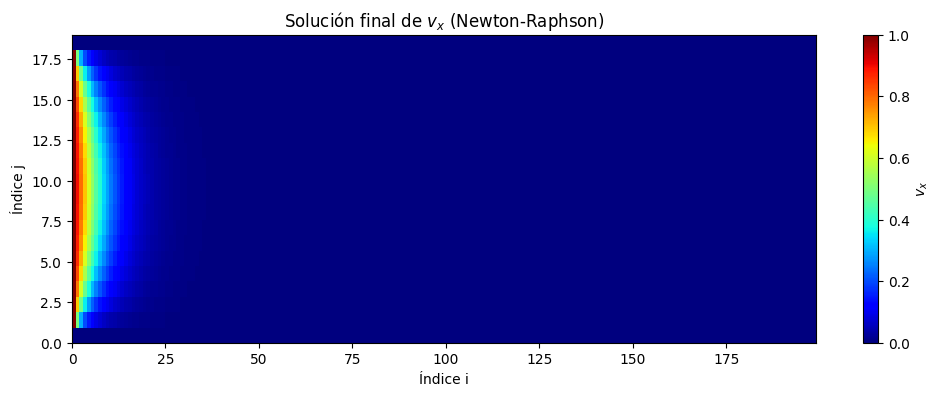

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt


def jacobi_solver(A, b, x0=None, tol=1e-8, maxiter=5000):
    """
    Resuelve el sistema Ax = b utilizando el método iterativo de Jacobi,
    basado en la fórmula:
    x^(k+1) = (I - Q^(-1)A)x^k + Q^(-1)b

    Parámetros:
    -----------
    A : array o matriz dispersa (sparse matrix)
        Matriz de coeficientes del sistema
    b : array
        Vector del lado derecho (términos independientes)
    x0 : array, opcional
        Aproximación inicial para la solución
    tol : float, opcional
        Tolerancia para el criterio de convergencia
    maxiter : int, opcional
        Número máximo de iteraciones permitidas

    Retorna:
    --------
    x : array
        Vector solución del sistema
    """
    n = len(b)

    # Inicializamos x
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = x0.copy()

    # En el método Jacobi, Q es la diagonal de A
    Q_diag = A.diagonal()
    Q_inv = 1.0 / Q_diag

    # Calcular Q^(-1)A
    Q_inv_A = sp.diags(Q_inv) @ A

    # Calcular (I - Q^(-1)A)
    I = sp.eye(n)
    iteration_matrix = I - Q_inv_A
    norm_iteration_matrix = np.linalg.norm(iteration_matrix.toarray(), ord=np.inf)

    if norm_iteration_matrix >= 1:
      print("Advertencia: El método de Jacobi podría no converger (||I - Q⁻¹A|| ≥ 1)")

    print(norm_iteration_matrix)

    # Create Q^(-1)b
    Q_inv_b = Q_inv * b

    # Perform iterations
    for k in range(maxiter):
        # Calculamos x^(k+1) = (I - Q^(-1)A)x^k + Q^(-1)b
        x_new = iteration_matrix @ x + Q_inv_b

        # Evaluamos la convergencia
        if np.linalg.norm(x_new - x) < tol:
          print(f"Jacobi convergió en {k} iter.")
          return x_new

        x = x_new

    print("Jacobi no convergió en", maxiter, "iteraciones")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01

    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny)) * 0.1 # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial
    vy[0, :] = 0.5

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver=jacobi_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()

# **Aplicando Gauss-Seidel**

En esta implementación, el sistema lineal se resuelve mediante el método iterativo de **Gauss‑Seidel**, una técnica clásica y robusta para resolver sistemas 𝐴𝑥 = 𝑏.

---

## **Método de Gauss-Seidel**

La función `gauss_seidel_solver` implementa el algoritmo de Gauss‑Seidel para resolver sistemas lineales 𝐴𝑥 = 𝑏, especialmente cuando la matriz 𝐴 se deriva de una discretización en malla (por ejemplo, una malla 2D).

- Se recorren las filas de la matriz dispersa (en formato CSR, por eficiencia).
- Se actualiza **secuencialmente** cada componente del vector solución `𝑥`, utilizando los valores **más recientes disponibles**.
- El método avanza fila por fila, corrigiendo el valor de `𝑥ᵢ` en cada paso de forma inmediata.

---

### **Ecuación de actualización:**

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1-RdzUHikUN-jXlxiUITQJFfXMyaYusOq" width="500"/>
</p>

---

## **¿Es Gauss-Seidel el mejor método para este problema?**

### ✅ **Por qué sí podría ser el mejor:**

- **Robusto ante Jacobianos generales**: No requiere que la matriz 𝐴 (o Jacobiano) sea simétrica ni definida positiva. Funciona incluso con matrices que surgen de sistemas no lineales con términos convectivos.
- **Estabilidad buena en práctica**: Es más **estable y menos sensible** que Gradiente Conjugado cuando las condiciones no son ideales.
- **Simplicidad de implementación**: Muy fácil de codificar, no necesita estructuras sofisticadas ni preacondicionadores.
- **Razonablemente rápido** para condiciones iniciales suaves (como vectores iniciales con 1 o 0).

### ❌ **Por qué no siempre es el mejor:**

- **Difícil de paralelizar**: Debido a las dependencias entre las actualizaciones del vector `𝑥`, no es adecuado para arquitecturas paralelas sin modificaciones.
- **Puede estancarse sin convergencia acelerada**: En problemas grandes, sin técnicas como sobre-relajación (SOR), puede ser lento.

Iteración 0: ||F|| = 1.26e+00
Gauss-Seidel convergió en 776 iteraciones.
Iteración 1: ||F|| = 2.90e+00
Gauss-Seidel convergió en 1015 iteraciones.
Iteración 2: ||F|| = 5.07e-03
Gauss-Seidel convergió en 561 iteraciones.
Iteración 3: ||F|| = 1.49e-07
Convergencia alcanzada.


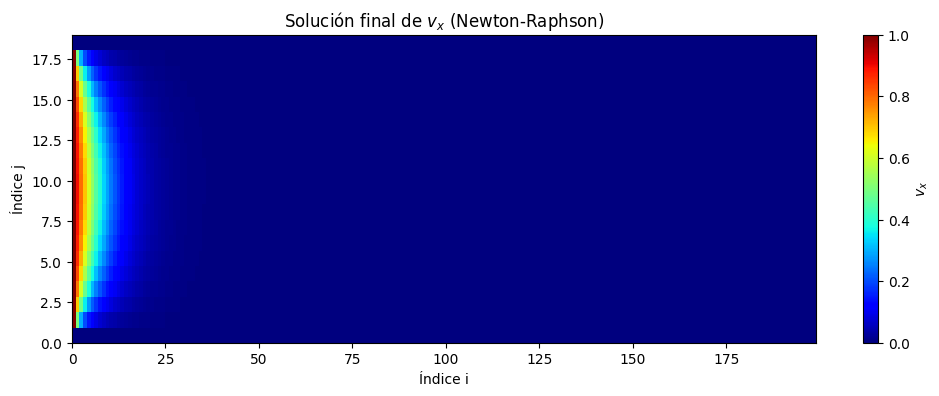

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import tril
from scipy.sparse.linalg import spsolve_triangular
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt


def gauss_seidel_solver(A, b, x0=None, tol=1e-8, maxiter=5000):
    """
    Resuelve el sistema Ax = b utilizando el método iterativo de Gauss-Seidel.

    Este método mejora sobre Jacobi usando los valores más recientes de x tan
    pronto como estén disponibles en cada iteración.

    Parámetros:
    -----------
    A : matriz dispersa (sparse matrix) en formato CSR
        Matriz de coeficientes del sistema
    b : array
        Vector del lado derecho (términos independientes)
    x0 : array, opcional
        Aproximación inicial para la solución
    tol : float, opcional
        Tolerancia para el criterio de convergencia
    maxiter : int, opcional
        Número máximo de iteraciones permitidas

    Retorna:
    --------
    x : array
        Vector solución del sistema
    """
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = x0.copy()

    # Nos aseguramos de trabajar con formato CSR
    A = A.tocsr()
    n = A.shape[0]

    # Como criterio heurístico, podemos advertir si la matriz no es diagonalmente dominante
    #diag_abs = np.abs(A.diagonal())
    #row_sum_abs = np.abs(A).sum(axis=1).A1 - diag_abs
    #if np.any(diag_abs < row_sum_abs):
    #    print("Advertencia: La matriz A no es diagonalmente dominante, Gauss-Seidel podría no converger.")

    for k in range(maxiter):
        x_old = x.copy()

        # Iteramos sobre cada fila
        for i in range(n):
            # Extraemos los índices y valores no nulos de la fila i
            row_start = A.indptr[i]
            row_end = A.indptr[i + 1]
            cols_i = A.indices[row_start:row_end]
            vals_i = A.data[row_start:row_end]

            sigma = 0.0
            a_ii = None

            # Recorremos la fila para calcular la suma y encontrar el pivote diagonal
            for idx_val, j in enumerate(cols_i):
                if j == i:
                    a_ii = vals_i[idx_val]
                else:
                    sigma += vals_i[idx_val] * x[j]  # usa x actualizado

            # if a_ii is None or a_ii == 0.0:
                # raise ValueError(f"Elemento diagonal cero encontrado en la fila {i}")

            # Actualizamos el valor de x[i]
            x[i] = (b[i] - sigma) / a_ii

        # Verificamos convergencia con norma infinita
        if np.linalg.norm(x - x_old, np.inf) < tol:
            print(f"Gauss-Seidel convergió en {k+1} iteraciones.")
            return x

    print("Gauss-Seidel no convergió en", maxiter, "iteraciones.")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.ones((nx, ny)) * 0.1  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver= gauss_seidel_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()


# **Aplicando método del Gradiente**
En esta implementación, el sistema lineal se resuelve mediante el método iterativo del Gradiente Conjugado (CG).

---

## **Método de Gradiente Conjugado**
La función conjugate_gradient_solver implementa el algoritmo de Gradiente Conjugado para resolver sistemas lineales del tipo 𝐴𝑥=𝑏, bajo la suposición de que la matriz 𝐴 es simétrica y definida positiva (SPD).

- Se construye una dirección de búsqueda conjugada en cada iteración.

- Se actualiza la solución con pasos óptimos a lo largo de esas direcciones.

- El método garantiza convergencia en N pasos (en exactitud matemática) si 𝐴 es SPD y se usan números reales (sin errores de redondeo).

---

### **Ecuación de actualización:**

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1VB7SG33S3Lz3t2SwYUL33ivNX-Wa_rox" width="700"/>
</p>

---

## **¿Es Gradiente Conjugado el mejor método para este problema?**
### **✅ Por qué sí podría ser el mejor:**
- Rendimiento en grandes sistemas dispersos: CG es especialmente eficiente cuando se usa con matrices dispersas grandes, como ocurre al discretizar ecuaciones en mallas 2D o 3D.

- No requiere almacenamiento completo de 𝐴: Solo necesita multiplicaciones por 𝐴, lo cual es ideal cuando 𝐴 se forma de forma implícita o como matriz dispersa.

- Convergencia rápida si 𝐴 es SPD: Si el Jacobiano 𝐽 es simétrico y definido positivo (lo cual se puede verificar o imponer), CG puede converger mucho más rápido que Gauss-Seidel.

### **❌ Por qué no siempre es el mejor:**
- 𝐽 puede no ser simétrico ni definido positivo: En problemas no lineales como este, el Jacobiano que surge de la discretización con términos convectivos frecuentemente no es simétrico y puede incluso ser indefinido. Esto viola las condiciones para aplicar CG de forma estricta.

- Estabilidad y convergencia no garantizadas: Si el sistema no cumple las condiciones ideales, el método puede no converger o producir resultados incorrectos.

- Sensibilidad al preacondicionamiento: CG suele requerir un buen precondicionador para ser eficiente en la práctica. En esta implementación no se incluye uno.

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh


def conjugate_gradient_solver(A, b, x0=None, tol=1e-8, maxiter=1000):
    """
    Resuelve el sistema Ax = b usando el método iterativo del Gradiente Conjugado.

    Este método es eficiente para matrices simétricas y definidas positivas (SPD).

    Parámetros:
    -----------
    A : matriz dispersa (sparse matrix) en formato CSR o matriz densa
        Matriz de coeficientes del sistema (debe ser SPD)
    b : array
        Vector del lado derecho (términos independientes)
    x0 : array, opcional
        Aproximación inicial para la solución
    tol : float, opcional
        Tolerancia para el criterio de convergencia
    maxiter : int, opcional
        Número máximo de iteraciones permitidas

    Retorna:
    --------
    x : array
        Vector solución del sistema
    """
    spd_tol = 0.01  # Tolerancia para verificar SPD
    spd_tol2 = 1e-6  # Tolerancia para verificar SPD

    # 1) A a CSR si es sparse
    if sp.isspmatrix(A):
        A = A.tocsr()
    n = b.size

    # 2) Comprobar simetría: A - Aᵀ cero (en formato CSR)
    if sp.isspmatrix(A):
        diff = A - A.transpose()
        print("Máxima diferencia entre A- Aᵀ: ",np.max(np.abs(diff.data)))
        if diff.nnz != 0 and np.max(np.abs(diff.data)) > spd_tol:
            print("A no es simétrica")
    else:
        if not np.allclose(A, A.T, atol=spd_tol):
            print("A no es simétrica")

    # 3) Comprobar definición positiva (k=1, smallest magnitude)
    try:
        lambda_min = eigsh(A, k=1, which='SM', return_eigenvectors=False)[0]
    except Exception as e:
        print("No se pudo estimar autovalor mínimo de A")

    if lambda_min <= spd_tol2:
        print(f"A no SPD (λ_min = {lambda_min:.2e} ≤ 0)")

    # 4) Inicializar x
    x = np.zeros_like(b) if x0 is None else x0.copy()
    r = b - A @ x
    p = r.copy()
    rs_old = np.dot(r, r)

    # 5) Iteraciones
    for k in range(maxiter):
        Ap = A @ p
        alpha = rs_old / np.dot(p, Ap)

        x += alpha * p
        r -= alpha * Ap

        rs_new = np.dot(r, r)
        if np.sqrt(rs_new) < tol:
            print(f"Gradiente Conjugado convergió en {k+1} iteraciones.")
            return x

        beta = rs_new / rs_old
        p = r + beta * p
        rs_old = rs_new

    print("Gradiente Conjugado no convergió en", maxiter, "iteraciones.")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.ones((nx, ny)) * 0.1  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver=conjugate_gradient_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()


# A**plicando Método del Gradiente Descendiente con Paso Óptimo**

Este método iterativo se utiliza para resolver sistemas lineales de la forma \( Ax = b \) cuando la matriz es **simétrica y definida positiva**, y se desea una solución utilizando técnicas iterativas simples con paso adaptativo.

## **Método Iterativo de Gradiente Descendiente**

La función `gradient_descent_adaptive` implementa el método del Gradiente Descendiente con paso óptimo, actualizando la solución iterativa con la fórmula:


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1R-OTn6J2Q1p7k-3YXmZmFm5Un_WS9IC-" width="300"/>
</p>

donde el valor del paso óptimo \(\alpha\) se calcula en cada iteración.

## ¿Es el Gradiente Descendiente el mejor método para este problema?

✅ **Ventajas**:

- **Implementación clara y estructurada**: El algoritmo es fácil de seguir, basado en productos matriz-vector.
- **Paso adaptativo**: Calcula el mejor paso en cada iteración, lo que mejora la eficiencia frente a un paso fijo.
- **Compatible con matrices dispersas**: Utiliza productos eficientes para matrices en formato disperso.

---

❌ **Limitaciones importantes**:

- **Requiere simetría**: El método asume que la matriz \(A\) es simétrica. Si no lo es, el algoritmo no debe ejecutarse.
- **Sensibilidad al número de condición**: Si la matriz está mal condicionada (número de condición alto), la convergencia puede ser muy lenta o no ocurrir.
- **No es adecuado para matrices generales**: Solo se recomienda cuando se cumple que \(A\) es simétrica y definida positiva. Para otros casos, se debe recurrir a métodos más robustos como GMRES o MINRES.

---

## **Conclusión: ¿Por qué no es adecuado para este problema?**

Aunque el método del gradiente descendiente tiene una implementación elegante y es eficiente en condiciones ideales, **no es adecuado para este problema** porque:

1. **La matriz Jacobiana no es simétrica**, lo cual rompe una condición fundamental del algoritmo.
2. **El número de condición es alto**, lo que impide una convergencia razonable y segura.
3. **El método no aprovecha estructuras complejas o precondicionadores**, lo que lo hace ineficiente en mallas grandes y problemas con sistemas mal condicionados como los que surgen de ecuaciones de Navier-Stokes.

> En resumen, este método es útil para problemas simples con matrices bien comportadas, pero **no escala bien** para simulaciones físicas reales y mal condicionadas.



In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def gradient_descent_adaptive(A, b, x0=None, tol=1e-8, maxiter=5000):
    """
    Método del gradiente descendente con paso óptimo para matrices dispersas.
    Ahora sigue iterando incluso si A no es SPD.

    Parámetros:
    -----------
    A : scipy.sparse.csc_matrix
        Matriz de coeficientes (posiblemente no SPD).
    b : ndarray
        Vector del término independiente.
    x0 : ndarray, opcional
        Aproximación inicial.
    tol : float
        Tolerancia de convergencia en la norma del residuo.
    maxiter : int
        Iteraciones máximas.

    Retorna:
    --------
    x : ndarray
        Aproximación final a la solución.
    """
    # 1) A en CSC para multiplicaciones rápidas
    if sp.issparse(A):
        A = A.tocsc()
    else:
        A = sp.csc_matrix(A)

    # 2) Intentamos estimar número de condición solo para aviso
    try:
        invA = spla.inv(A)
        cond = spla.norm(A, 2) * spla.norm(invA, 2)
        print(f"Número de condición estimado de A: {cond:.2e}")
        if cond > 1e2:
            print("Matriz mal condicionada, GD puede tardar o divergir, pero seguimos.")
    except Exception:
        print("No pudo estimarse número de condición, seguimos de todas formas.")

    # 3) Aviso de simetría pero sin interrumpir
    diff = A - A.transpose()
    if diff.nnz != 0 and np.max(np.abs(diff.data)) > 1e-14:
        print("A no es simétrica dentro de tolerancia, GD seguirá iterando.")

    # 4) Inicialización
    x = np.zeros_like(b) if x0 is None else x0.copy()

    for k in range(1, maxiter+1):
        r = b - A @ x
        Ar = A @ r

        num = r.dot(r)
        den = r.dot(Ar)
        if den == 0:
            print(f"Denominador nulo en iteración {k}, detenemos.")
            break

        alpha = num / den
        x += alpha * r

        if np.linalg.norm(r) < tol:
            print(f"Gradiente Descendiente convergió en {k} iteraciones (|r| < {tol}).")
            return x

    print(f"Gradiente Descendiente no convergió en {maxiter} iteraciones.")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.ones((nx, ny)) * 0.1  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(0, nx, 20):  # Iteramos de 20 en 20, desde 0 hasta 200
        # Calculamos el valor de vx para el bloque actual
        valor_vx = 1 - 0.1 * (i // 20)  # Disminuir en 0.1 por cada bloque
        # Asignamos el valor de vx a las 20 columnas correspondientes
        vx[i:i+20, :] = valor_vx

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver=gradient_descent_adaptive)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()

# **Conclusión general**

### **Comparativa de Métodos Iterativos**

| **Método**          | **Convergencia**       | **Requiere matriz SPD** | **Estabilidad** | **Facilidad implementación** | **Paralelización** |
|---------------------|------------------------|--------------------------|------------------|-------------------------------|---------------------|
| **Jacobi**          | Lenta                  | ❌                       | Moderada         | ✅ Muy fácil                  | ✅ Excelente         |
| **Gauss-Seidel**    | Rápida (si domina)     | ❌                       | ✅ Robusto       | ✅ Fácil                      | ❌ Difícil           |
| **Gradiente Conj.** | Muy rápida (si SPD)    | ✅ Necesaria             | ❌ Sensible      | ⚠️ Medio                      | ✅ Excelente         |

---

### **Criterio según el escenario**

| **Escenario**                           | **Método Recomendado**   | **Razón**                                                                 |
|----------------------------------------|---------------------------|----------------------------------------------------------------------------|
| Sistema no lineal + Jacobiano general  | ✅ **Gauss-Seidel**       | Robusto, estable y razonablemente rápido para condiciones suaves          |
| Sistema lineal o Jacobiano SPD         | ✅ **Gradiente Conjugado**| Muy eficiente, pero solo si se garantiza la condición SPD                 |
| Implementación simple y paralela       | ✅ **Jacobi**              | Buena opción para prototipos paralelos, aunque muy lento sin relajación   |

---

### **Método escogido**

> **Gauss-Seidel**:  
> Es más **robusto** que Gradiente Conjugado y más **rápido** que Jacobi. Las condiciones iniciales suaves (valores 1 y 0) ayudan a su convergencia, y no dependes de que el Jacobiano sea SPD.


Iteración 0: ||F|| = 4.62e-01
Gauss-Seidel convergió en 610 iteraciones.
Iteración 1: ||F|| = 2.65e+00
Gauss-Seidel convergió en 1014 iteraciones.
Iteración 2: ||F|| = 1.21e-03
Gauss-Seidel convergió en 546 iteraciones.
Iteración 3: ||F|| = 1.42e-07
Convergencia alcanzada.


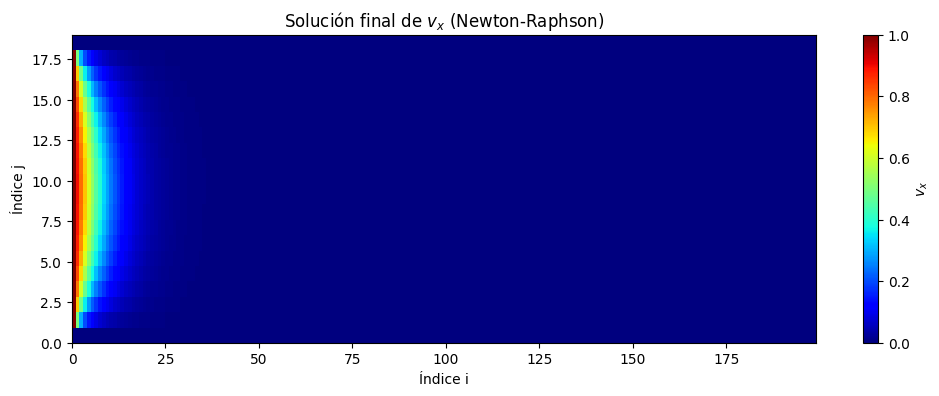

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import tril
from scipy.sparse.linalg import spsolve_triangular
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def gauss_seidel_solver(A, b, x0=None, tol=1e-8, maxiter=5000):
    """
    Resuelve el sistema Ax = b utilizando el método iterativo de Gauss-Seidel.

    Este método mejora sobre Jacobi usando los valores más recientes de x tan
    pronto como estén disponibles en cada iteración.

    Parámetros:
    -----------
    A : scipy.sparse.csr_matrix
        Matriz de coeficientes del sistema (en formato CSR).
    b : ndarray
        Vector del lado derecho (términos independientes).
    x0 : ndarray, opcional
        Aproximación inicial para la solución. Si no se proporciona, se usa un
        vector nulo.
    tol : float, opcional
        Tolerancia para el criterio de convergencia (norma infinito del cambio).
    maxiter : int, opcional
        Número máximo de iteraciones permitidas.

    Retorna:
    --------
    x : ndarray
        Vector solución aproximada del sistema Ax = b.
    """
    # Vector inicial
    x = np.zeros_like(b) if x0 is None else x0.copy()

    # Asegurarnos de trabajar en CSR
    if not sp.isspmatrix_csr(A):
        A = A.tocsr()
    n = A.shape[0]

    # Comprobación de dominancia diagonal (solo indicador, no aborta)
    #abs_diag = np.abs(A.diagonal())
    #abs_row_sums = np.abs(A).sum(axis=1).A1 - abs_diag
    #viol = np.where(abs_diag < abs_row_sums)[0]
    #if viol.size:
        #print(f"Advertencia: A no es diagonalmente dominante en filas {viol.tolist()}.")
        # Sigue la ejecución de todos modos...

    # Iteraciones de Gauss-Seidel
    for k in range(1, maxiter+1):
        x_old = x.copy()

        # Un sweep sobre cada fila
        for i in range(n):
            row_start, row_end = A.indptr[i], A.indptr[i+1]
            cols = A.indices[row_start:row_end]
            vals = A.data   [row_start:row_end]

            # Separar término diagonal y sumas
            a_ii = 0.0
            sigma = 0.0
            for j, a_ij in zip(cols, vals):
                if j == i:
                    a_ii = a_ij
                else:
                    sigma += a_ij * x[j]   # usa x actualizado

            # Si a_ii es muy pequeño, marcamos la fila y saltamos
            if abs(a_ii) < 1e-16:
                print(f"  ⚠ Fila {i}: pivote casi cero (|a_ii|={a_ii:.2e}).")
                continue

            x[i] = (b[i] - sigma) / a_ii

        # Criterio de parada: norma infinito del cambio
        if np.linalg.norm(x - x_old, np.inf) < tol:
            print(f"Gauss-Seidel convergió en {k} iteraciones.")
            return x

    print(f"Gauss-Seidel no convergió en {maxiter} iteraciones.")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.ones((nx, ny)) * 0.1  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver= gauss_seidel_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(12, 4))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()


# **--------------Spline cúbico natural y código final--------------**

Finalmente, se presenta la última versión del código del proyecto y se plotean los resultados obtenidos.



Iteración 0: ||F|| = 4.62e-01
Gauss-Seidel convergió en 610 iteraciones.
Iteración 1: ||F|| = 2.65e+00
Gauss-Seidel convergió en 1014 iteraciones.
Iteración 2: ||F|| = 1.21e-03
Gauss-Seidel convergió en 546 iteraciones.
Iteración 3: ||F|| = 1.42e-07
Convergencia alcanzada.


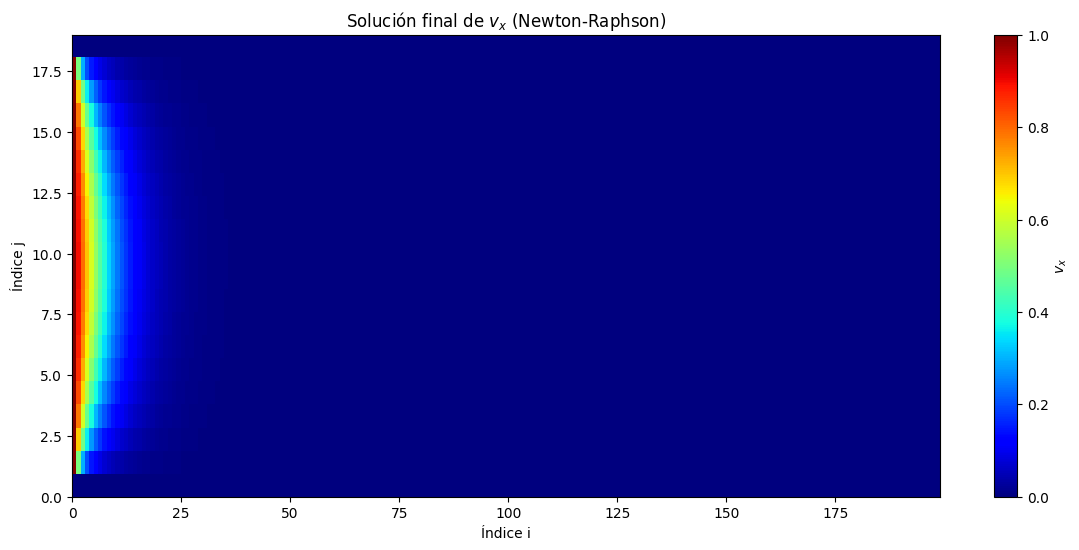

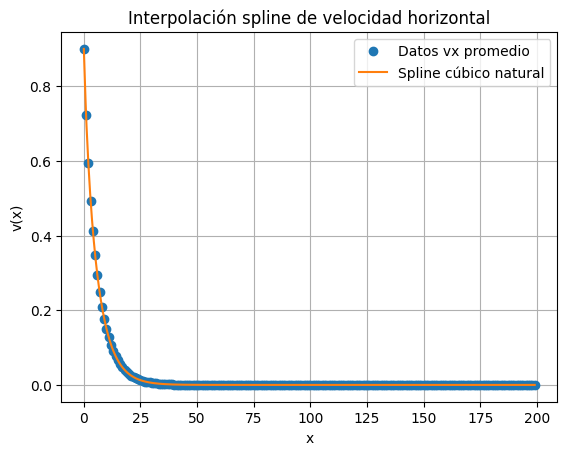

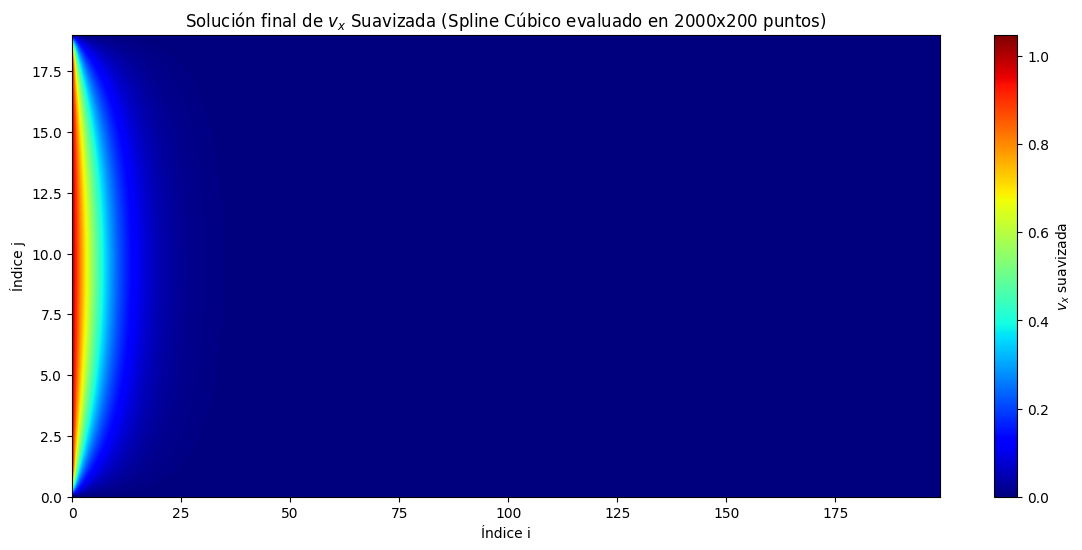

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import tril
from scipy.sparse.linalg import spsolve_triangular
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline , RectBivariateSpline

def idx(i, j, ny):
    return (i - 1) * (ny - 2) + (j - 1)

def compute_jacobian_vx(vx, vy, h, nx, ny):
    """
    Construye el Jacobiano de F respecto a vx en los nodos interiores.

    Se usan las derivadas:
      - Diagonal: ∂F/∂vx(i,j) = 1 + (h/(8))*[vx(i+1,j)-vx(i-1,j)]
      - Vecino este:  ∂F/∂vx(i+1,j) = -1/4 + (h/(8))*vx(i,j)
      - Vecino oeste:  ∂F/∂vx(i-1,j) = -1/4 - (h/(8))*vx(i,j)
      - Vecino norte:  ∂F/∂vx(i,j+1) = -1/4 + (h/(8))*vy(i,j)
      - Vecino sur:    ∂F/∂vx(i,j-1) = -1/4 - (h/(8))*vy(i,j)

    Se asume que los vecinos que no son nodos interiores ya tienen valores fijos.
    """
    alpha = 0.5 * h  # Factor h/2
    N = (nx - 2) * (ny - 2)
    rows = []
    cols = []
    data = []

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            k = idx(i, j, ny)
            # Derivada diagonal: ∂F/∂vx(i,j)
            diag = 1.0
            # Contribución de la parte convectiva:
            if i + 1 < nx:
                diag += 0.25 * alpha * vx[i+1, j]
            if i - 1 >= 0:
                diag -= 0.25 * alpha * vx[i-1, j]
            rows.append(k)
            cols.append(k)
            data.append(diag)

            # Vecino al este: vx(i+1,j)
            if i + 1 < nx - 1:  # interior
                k_east = idx(i + 1, j, ny)
                val_east = -0.25 + 0.25 * alpha * vx[i, j]
                rows.append(k)
                cols.append(k_east)
                data.append(val_east)

            # Vecino al oeste: vx(i-1,j)
            if i - 1 >= 1:  # interior
                k_west = idx(i - 1, j, ny)
                val_west = -0.25 - 0.25 * alpha * vx[i, j]
                rows.append(k)
                cols.append(k_west)
                data.append(val_west)

            # Vecino al norte: vx(i,j+1)
            if j + 1 < ny - 1:  # interior
                k_north = idx(i, j + 1, ny)
                val_north = -0.25 + 0.25 * alpha * vy[i, j]
                rows.append(k)
                cols.append(k_north)
                data.append(val_north)

            # Vecino al sur: vx(i,j-1)
            if j - 1 >= 1:  # interior
                k_south = idx(i, j - 1, ny)
                val_south = -0.25 - 0.25 * alpha * vy[i, j]
                rows.append(k)
                cols.append(k_south)
                data.append(val_south)

    J = sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()
    return J

def compute_F(vx, vy, h, nx, ny):
    """
    Calcula el vector residual F para cada nodo interior,
    usando la ecuación:

      F_{i,j}(v_x) = v_x(i,j) - 1/4 * [ v_x(i+1,j) + v_x(i-1,j) + v_x(i,j+1) + v_x(i,j-1)
                         - (h/2)*v_x(i,j)*(v_x(i+1,j)-v_x(i-1,j))
                         - (h/2)*v_y(i,j)*(v_x(i,j+1)-v_x(i,j-1)) ]
    """
    F = np.zeros((nx - 2, ny - 2))
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            term = vx[i+1, j] + vx[i-1, j] + vx[i, j+1] + vx[i, j-1]
            conv1 = (h/2.0) * vx[i, j] * (vx[i+1, j] - vx[i-1, j])
            conv2 = (h/2.0) * vy[i, j] * (vx[i, j+1] - vx[i, j-1])
            F[i-1, j-1] = vx[i, j] - 0.25 * (term - conv1 - conv2)
    return F.flatten()

def newton_solver_vx(vx, vy, h, nx, ny, solver, max_iter=50, tol=1e-6):
    """
    Resuelve el sistema F(vx) = 0 para los nodos interiores mediante Newton-Raphson.
    Se actualiza únicamente vx en el dominio interior, reimponiéndose las condiciones
    de frontera en cada iteración.
    """
    for it in range(max_iter):
        F = compute_F(vx, vy, h, nx, ny)
        normF = np.linalg.norm(F)
        print(f"Iteración {it}: ||F|| = {normF:.2e}")
        if normF < tol:
            print("Convergencia alcanzada.")
            break
        J = compute_jacobian_vx(vx, vy, h, nx, ny)
        delta = solver(J, -F)
        if delta is None:
            print("Se detiene el método de Newton-Raphson porque el sistema lineal no pudo resolverse con gradiente descendente.")
            return None
        # Actualizamos los nodos interiores:
        vx_interior = vx[1:nx-1, 1:ny-1].flatten() + delta
        vx[1:nx-1, 1:ny-1] = vx_interior.reshape((nx-2, ny-2))
        # Reimponemos las condiciones de frontera:
        vx[0, :] = 1.0   # Borde izquierdo:
        vx[-1, :] = 0.0   # Borde derecho
        vx[:, 0] = 0.0    # Borde inferior
        vx[:, -1] = 0.0   # Borde superior
    return vx

def gauss_seidel_solver(A, b, x0=None, tol=1e-8, maxiter=5000):
    """
    Resuelve el sistema Ax = b utilizando el método iterativo de Gauss-Seidel.

    Este método mejora sobre Jacobi usando los valores más recientes de x tan
    pronto como estén disponibles en cada iteración.

    Parámetros:
    -----------
    A : scipy.sparse.csr_matrix
        Matriz de coeficientes del sistema (en formato CSR).
    b : ndarray
        Vector del lado derecho (términos independientes).
    x0 : ndarray, opcional
        Aproximación inicial para la solución. Si no se proporciona, se usa un
        vector nulo.
    tol : float, opcional
        Tolerancia para el criterio de convergencia (norma infinito del cambio).
    maxiter : int, opcional
        Número máximo de iteraciones permitidas.

    Retorna:
    --------
    x : ndarray
        Vector solución aproximada del sistema Ax = b.
    """
    # Vector inicial
    x = np.zeros_like(b) if x0 is None else x0.copy()

    # Asegurarnos de trabajar en CSR
    if not sp.isspmatrix_csr(A):
        A = A.tocsr()
    n = A.shape[0]

    # Comprobación de dominancia diagonal (solo indicador, no aborta)
    abs_diag = np.abs(A.diagonal())
    abs_row_sums = np.abs(A).sum(axis=1).A1 - abs_diag
    viol = np.where(abs_diag < abs_row_sums)[0]

    # Iteraciones de Gauss-Seidel
    for k in range(1, maxiter+1):
        x_old = x.copy()

        # Un sweep sobre cada fila
        for i in range(n):
            row_start, row_end = A.indptr[i], A.indptr[i+1]
            cols = A.indices[row_start:row_end]
            vals = A.data   [row_start:row_end]

            # Separar término diagonal y sumas
            a_ii = 0.0
            sigma = 0.0
            for j, a_ij in zip(cols, vals):
                if j == i:
                    a_ii = a_ij
                else:
                    sigma += a_ij * x[j]   # usa x actualizado

            # Si a_ii es muy pequeño, marcamos la fila y saltamos
            if abs(a_ii) < 1e-16:
                print(f"  ⚠ Fila {i}: pivote casi cero (|a_ii|={a_ii:.2e}).")
                continue

            x[i] = (b[i] - sigma) / a_ii

        # Criterio de parada: norma infinito del cambio
        if np.linalg.norm(x - x_old, np.inf) < tol:
            print(f"Gauss-Seidel convergió en {k} iteraciones.")
            return x

    print(f"Gauss-Seidel no convergió en {maxiter} iteraciones.")
    return x


# -------------------- PROGRAMA PRINCIPAL --------------------
if __name__ == "__main__":
    # Definición de la malla y parámetros:
    nx, ny = 200, 20
    h = 0.01
    # Inicializamos vx y vy en toda la malla:
    vx = np.zeros((nx, ny))
    vy = np.ones((nx, ny)) * 0.1  # Todos los valores de vy serán 0.1

    # Imponemos la condición inicial de vx
    for i in range(10):  # 10 bloques
        valor_vx = round(0.9 - 0.1 * i, 1)  # Valor decreciente por bloque
        vx[i*20:(i+1)*20, :] = valor_vx  # Llenar las columnas del bloque completo

    vx[0, :] = 1 # Damos el valor de 1 a la columna de condiciones inicial

    # Resolvemos el sistema para vx usando Newton-Raphson:
    vx_sol = newton_solver_vx(vx, vy, h, nx, ny, solver= gauss_seidel_solver)
    # Verificamos si vx_sol es None antes de continuar:
    if vx_sol is None:
        print("La solución no pudo converger. Deteniendo el programa.")
    else:
      # Ploteamos la solución de vx:
      plt.figure(figsize=(14, 6))
      plt.imshow(vx_sol.T, origin='lower', aspect='auto', cmap='jet',
                extent=[0, nx-1, 0, ny-1])
      plt.colorbar(label='$v_x$')
      plt.title('Solución final de $v_x$ (Newton-Raphson)')
      plt.xlabel('Índice i')
      plt.ylabel('Índice j')
      plt.show()

# SPLINES
from scipy.interpolate import CubicSpline
v_promedio_x = np.mean(vx_sol, axis=1)
v_interp = CubicSpline(np.arange(nx), v_promedio_x, bc_type='natural')

# Promediamos en y para obtener v(x) promedio a lo largo del eje vertical
v_promedio_x = np.mean(vx_sol, axis=1)  # Resultado: array de tamaño (nx,)


# Creamos arreglo de posiciones en x (en número de nodos)
x_nodes = np.arange(nx)  # [0, 1, 2, ..., 199]

# Spline cúbico natural: velocidad en función de x
v_interp = CubicSpline(x_nodes, v_promedio_x, bc_type='natural')

x_eval = np.linspace(0, nx-1, 500)
v_eval = v_interp(x_eval)

plt.plot(x_nodes, v_promedio_x, 'o', label='Datos vx promedio')
plt.plot(x_eval, v_eval, '-', label='Spline cúbico natural')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.title('Interpolación spline de velocidad horizontal')
plt.legend()
plt.grid()
plt.show()

# Suavizado con Spline Cúbico y Mayor Densidad de Puntos


# Definimos una nueva grilla más densa para la evaluación
nx_interp = 2000  # Más puntos en x
ny_interp = 200   # Más puntos en y

x_coords_original = np.arange(nx)
y_coords_original = np.arange(ny)

# Creamos el objeto spline bidimensional usando los datos originales
spl = RectBivariateSpline(x_coords_original, y_coords_original, vx_sol)

# Creamos los nuevos rangos de coordenadas para la evaluación más densa
x_eval = np.linspace(0, nx - 1, nx_interp)
y_eval = np.linspace(0, ny - 1, ny_interp)

# Evaluamos el spline en la nueva grilla más densa
vx_smoothed = spl(x_eval, y_eval)

# Ploteamos la solución de vx suavizada con la nueva grilla:
plt.figure(figsize=(14, 6))
plt.imshow(vx_smoothed.T, origin='lower', aspect='auto', cmap='jet',
extent=[0, nx-1, 0, ny-1])
plt.colorbar(label='$v_x$ suavizada')
plt.title(f'Solución final de $v_x$ Suavizada (Spline Cúbico evaluado en {nx_interp}x{ny_interp} puntos)')
plt.xlabel('Índice i')
plt.ylabel('Índice j')
plt.show()

